In [1]:
import umap
import umap.plot 
import os
import seaborn as sbs
import matplotlib.pyplot as plt
import sklearn 
from sklearn.utils import shuffle
from sklearn.preprocessing import PowerTransformer, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

D:\conda\Lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [2]:
classes_list = os.listdir('classes_features/')
labels = []
classes_list_buffer = {}
data = pd.DataFrame()
j = 0
for i, model_class in enumerate(classes_list):
    proccessed_tf = (model_class.split('_')[0] == 'processed')
    j += 1
    if proccessed_tf:
        data_model = pd.read_csv(f'classes_features/{model_class}')
        model_name = model_class.split('.')[:-1][0][10:]
        data_model['NM'] = j
        data = pd.concat([data, data_model]) 
        classes_list_buffer[j] = model_name
    else:
        j -= 1
data = shuffle(data, random_state=42)
data.reset_index(drop=True, inplace=True)
data = data.drop('sid', axis=1)

In [3]:
calls = data['NM'].copy()
data = data.drop('NM', axis=1)
data_train = data.copy()
data_targets = calls.copy()
pipe = [PowerTransformer(), RobustScaler(), QuantileTransformer(random_state=42)]
data_train = pipe[2].fit_transform(data_train.copy())
data_train = pd.DataFrame(data_train, columns=['BUFF','NOT','AND','PI','PO','LP'])
data['NM'] = calls

In [4]:
#data_train = data_train.div(data_train.max())
#data_train

In [5]:
class UmapObjectPainter():
    def __init__(self, embedding, data_targets, data_train=None, classes_list_buffer=None):
        self.embedding = embedding
        self.data_train = data_train
        self.data_targets = data_targets
        self.classes_list_buffer = classes_list_buffer
        
    def plt_embeds_painter(self) -> None:
        self.embedding_plt = self.embedding.transform(self.data_train)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(self.embedding_plt[:,0], self.embedding_plt[:,1], c=self.data_targets, cmap='tab20')
        
    def umap_embeds_painter(self) -> None:
        umap.plot.points(self.embedding, labels=self.data_targets, cmap='tab20', theme='fire', width=1300)
    
    def interactive_painter(self) -> None:
        hover_data = pd.DataFrame({'index':np.arange(43500), 'label':self.data_targets})
        hover_data['item'] = hover_data.label.map(self.classes_list_buffer)

        p = umap.plot.interactive(self.embedding, labels=self.data_targets, hover_data=hover_data, point_size=2,
                                 tools=["pan","wheel_zoom","box_zoom","save","reset","help",])
        umap.plot.show(p)

1. Параметрический метод снижения размерности методом UMAP. Обучаю полносвязную сеть(в данном случае стандартная НС из оригинальной реализации UMAP оказалась достаточно хорошей для разделения классов), далее UMAP использует эту сеть для установления взаимосвязи между входными данными(data) и пространством эмбеддингов.

In [6]:
tf.keras.utils.set_random_seed(42)
TFUmapEncoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=6),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(units=48, activation="gelu"),
    #tf.keras.layers.Dense(units=64, activation="gelu"),
    #tf.keras.layers.Dense(units=8, activation="gelu"),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=2),
])
TFUmapEncoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 100)               700       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 21102 (82.43 KB)
Trainable params: 21102 (82.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
umap_embed = umap.ParametricUMAP(verbose=True, n_neighbors=27, encoder=TFUmapEncoder, min_dist=0, random_state=42)

In [8]:
embedding = umap_embed.fit(data_train)

ParametricUMAP(encoder=<keras.src.engine.sequential.Sequential object at 0x00000273C09D6C50>, optimizer=<keras.src.optimizers.adam.Adam object at 0x00000273C09D7990>)
Sun Sep 24 17:16:54 2023 Construct fuzzy simplicial set
Sun Sep 24 17:16:54 2023 Finding Nearest Neighbors
Sun Sep 24 17:16:54 2023 Building RP forest with 15 trees
Sun Sep 24 17:16:57 2023 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Sun Sep 24 17:17:19 2023 Finished Nearest Neighbor Search
Sun Sep 24 17:17:22 2023 Construct embedding
Epoch 1/10
7330/7330 [==============================] - 49s 6ms/step - loss: 0.1299
Epoch 2/10
7330/7330 [==============================] - 48s 7ms/step - loss: 0.1263
Epoch 3/10
7330/7330 [==============================] - 48s 6ms/step - loss: 0.1261
Epoch 4/10
7330/7330 [==============================] - 47s 6ms/step - loss: 0.1258
Epoch 5/10
7330/7330 [==============================] - 47s 6ms/step - loss: 0.1259
Epoch 6/10
7330

In [9]:
# umap_embed._history
# fig, ax = plt.subplots()
# ax.plot(umap_embed._history['loss'])
# ax.set_ylabel('Cross Entropy')
# ax.set_xlabel('Epoch')

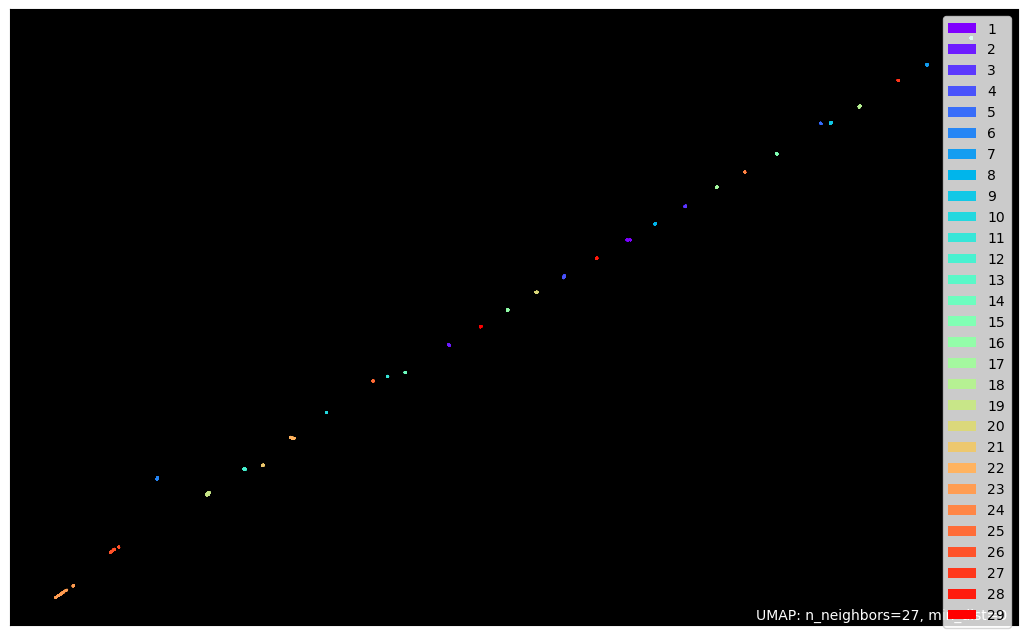

In [10]:
ft = UmapObjectPainter(embedding, data_targets, data_train, classes_list_buffer)
ft.umap_embeds_painter()
ft.interactive_painter()

In [11]:
for key, value in classes_list_buffer.items():
    print("{0}: {1}".format(key,value))

1: ac97_ctrl
2: aes
3: aes_secworks
4: aes_xcrypt
5: bp_be
6: des3_area
7: dft
8: dynamic_node
9: ethernet
10: fir
11: fpu
12: i2c
13: idft
14: iir
15: jpeg
16: mem_ctrl
17: pci
18: picosoc
19: sasc
20: sha256
21: simple_spi
22: spi
23: ss_pcm
24: tinyRocket
25: tv80
26: usb_phy
27: vga_lcd
28: wb_conmax
29: wb_dma


2. Стандартный(непараметрический) метод снижения размерности UMAP. Обучение эмбеддингам напрямую без НС.

In [12]:
embed_space = umap.UMAP(n_neighbors=105, min_dist=0.7, metric='mahalanobis', init='pca', random_state=42, repulsion_strength=0.0001, negative_sample_rate=1, verbose=True).fit(data_train)

UMAP(init='pca', metric='mahalanobis', min_dist=0.7, n_neighbors=105, negative_sample_rate=1, random_state=42, repulsion_strength=0.0001, verbose=True)
Sun Sep 24 17:25:42 2023 Construct fuzzy simplicial set
Sun Sep 24 17:25:42 2023 Finding Nearest Neighbors
Sun Sep 24 17:25:42 2023 Building RP forest with 15 trees
Sun Sep 24 17:25:42 2023 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	Stopping threshold met -- exiting after 6 iterations
Sun Sep 24 17:27:12 2023 Finished Nearest Neighbor Search
Sun Sep 24 17:27:18 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Sep 24 17:27:53 2023 Finished embedding


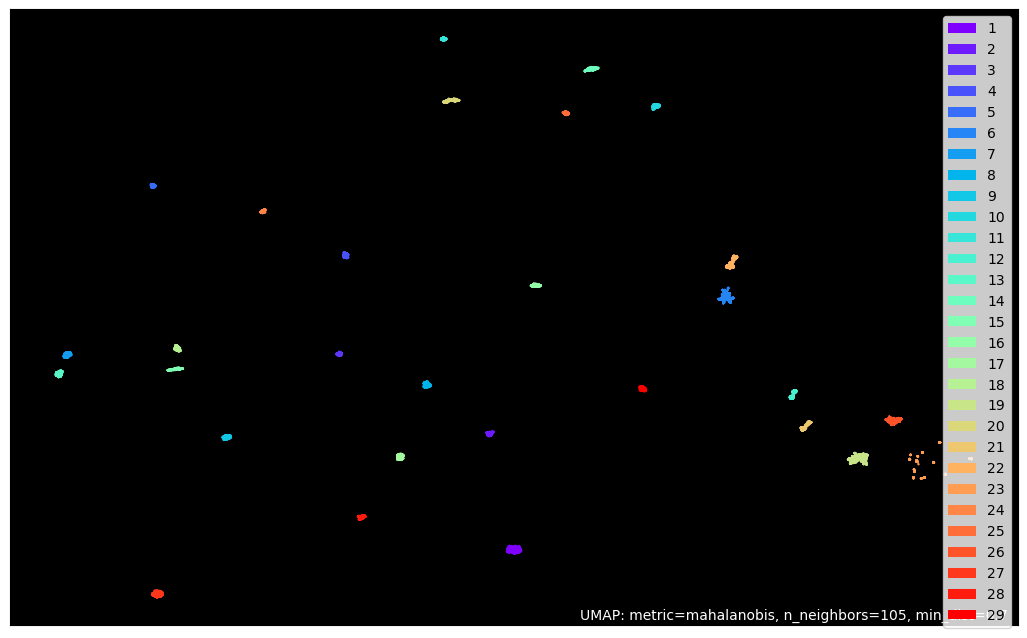

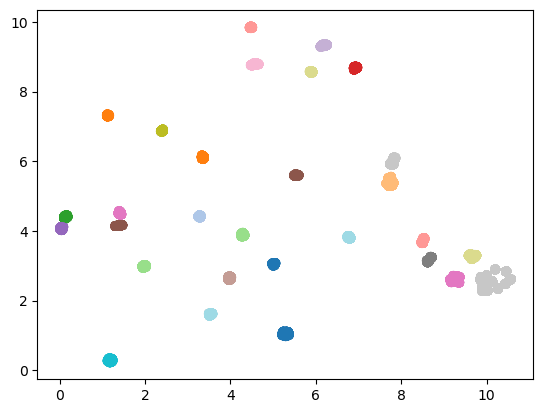

In [13]:
kt = UmapObjectPainter(embed_space, data_targets, data_train, classes_list_buffer)
kt.umap_embeds_painter()
kt.plt_embeds_painter()
kt.interactive_painter()

Приведены 2 эффективных способа снижения размерности с помощью библиотеки UMAP для визуализации и разделения 1500 экземпляров 29-ти классов логических схем